# Demo - Approximate GP Posterior

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.mcmc import MCTransform

import numpy as onp
onp.random.seed(123)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 10
ntest = 1_000
input_cov = 0.3

output_cov = 0.05
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

In [3]:
def real_f(x):
    mu = np.zeros_like(x[:, 0])
    cov = kernel(x, x) + 1e-5 * np.identity(x.shape[0])
    return jax.random.multivariate_normal(key, mu,  cov )

In [4]:
key = jax.random.PRNGKey(123)
length_scale = 0.1

kernel = RBF(length_scale)
ntrain = 30
X = np.linspace(-10, 10, ntrain)[:, None]
mu = np.zeros_like(X[:, 0])
y = jax.random.multivariate_normal(key, mu, kernel(X, X))

In [5]:

ntrain = 10
ntest = 1_000

X = np.linspace(-10, 10, ntrain)[:, None]
Xtest = np.linspace(-10.1, 10.1, ntest)[:, None]
y = real_f(X) + output_cov * jax.random.normal(key, (ntrain,))
# ytest = real_f(Xtest)

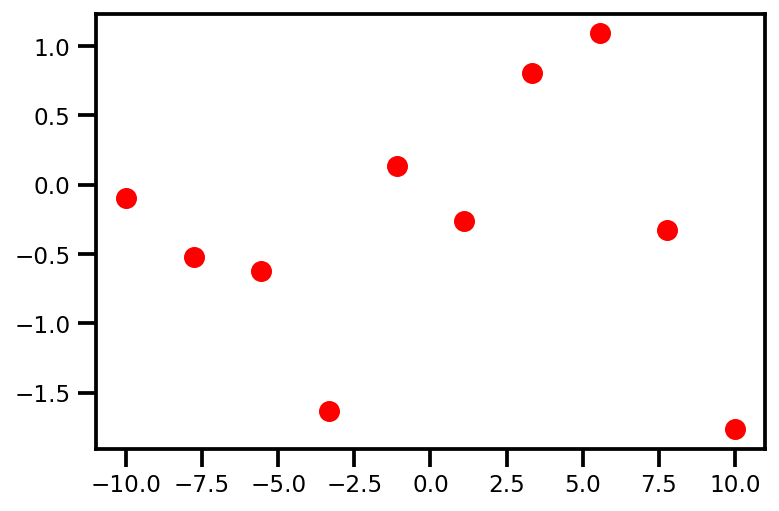

In [6]:
plt.scatter(X, y, color='red')
# plt.plot(Xtest, ytest)

## Model

In [7]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


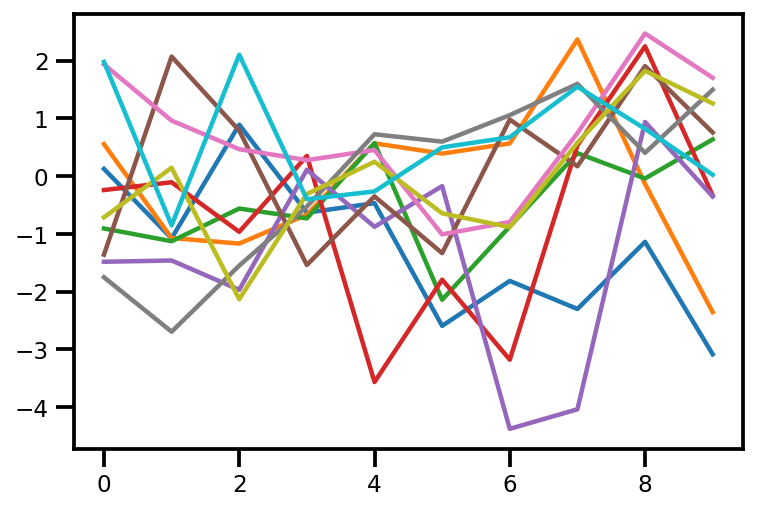

In [8]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [9]:
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.SGD,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:01<00:00, 529.88it/s, Loss=12.90]


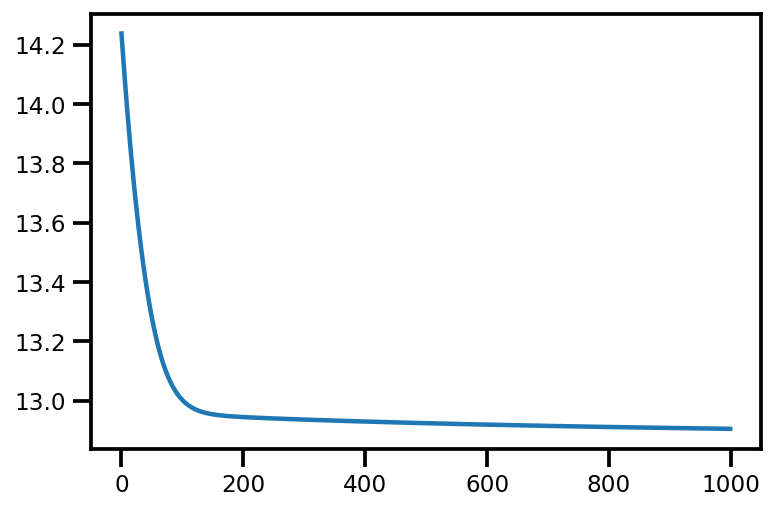

In [10]:
plt.plot(losses)

In [11]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [0.16597566] [0.7795745] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [1.2341417] [1.4896243] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [1.5959784] [1.7805558] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-0.9522375] [0.3263329] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [12]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

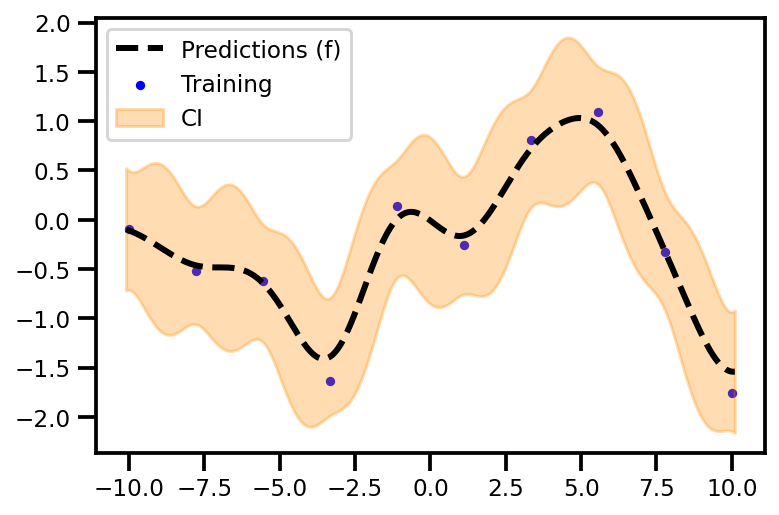

In [13]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [14]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

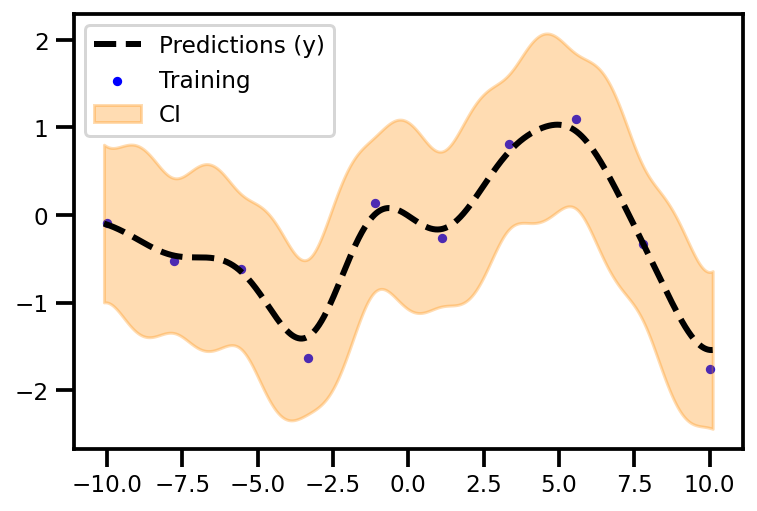

In [15]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Monte Carlo Sampling

In [16]:
from jaxkern.gp.uncertain.mcmc import get_mc_sigma_points, MCTransform
from jaxkern.gp.predictive import predictive_mean

In [17]:
x_sample = np.array([-0.1])
x_samples_cov = np.tile(np.diag(np.array([0.2])), (1, 1))

# 
n_mc_points = 10_000

# initialize model
mc_model = MCTransform(model, jitted=True, seed=123)

# generate sigma points
sigma_pts  = get_mc_sigma_points(mc_model.key, 1, (n_mc_points,))

# get function
f = jax.vmap(jax.partial(predictive_mean, model))
df = jax.vmap(jax.grad(jax.partial(predictive_mean, model)))

# calculate sigma points
x_mc_samples = x_sample + np.linalg.cholesky(x_samples_cov) @ sigma_pts.T

print(x_mc_samples.shape)

(1, 10000)


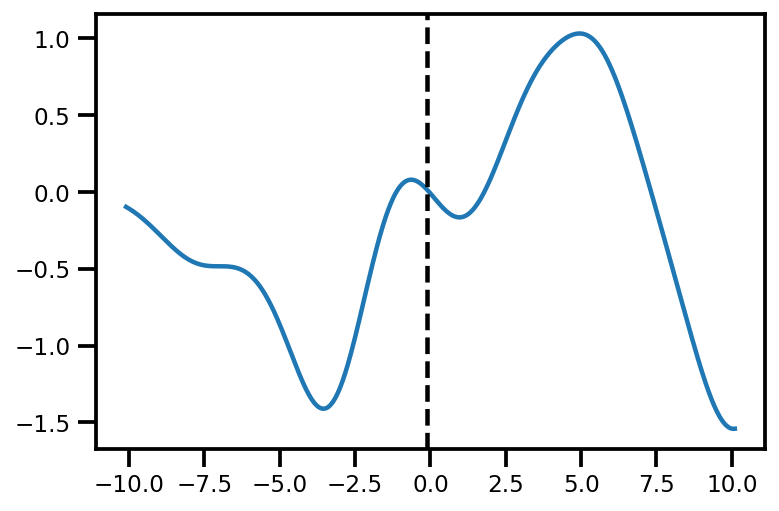

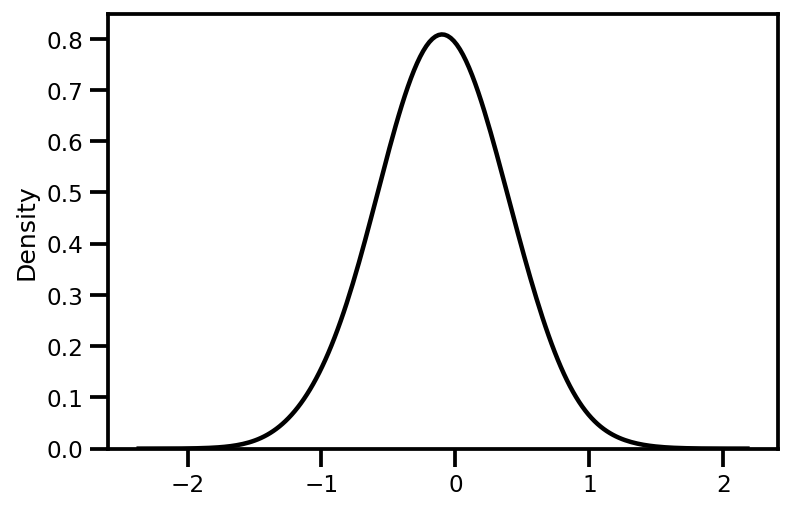

In [18]:
mu = f(Xtest)

# plt.hist(x_mc_samples.squeeze(), bins=100, density=True);
plt.figure()
plt.plot(Xtest, mu)
plt.axvline(x_sample, linestyle="--", color='black')
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(x=x_mc_samples.squeeze(), bw_adjust=3., color='black')
plt.show()

In [19]:
y_mc_samples = f(x_mc_samples.T)

<AxesSubplot:ylabel='Density'>

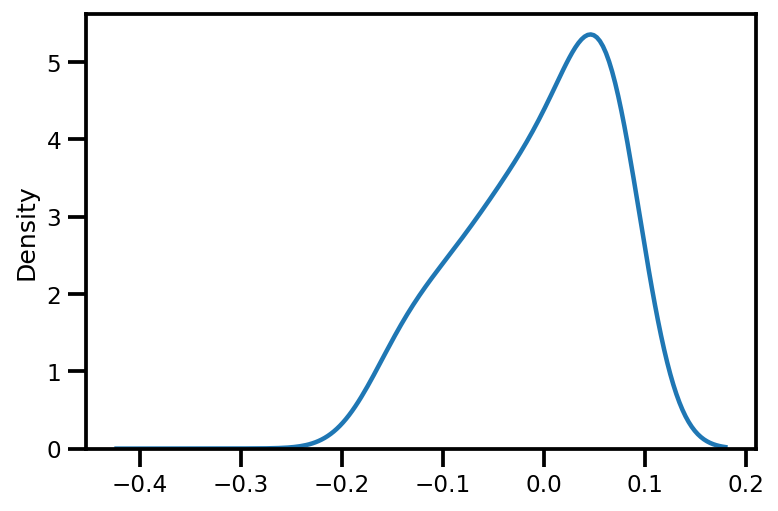

In [20]:
# plt.hist(y_mc_samples.squeeze(), bins=100, density=True);
sns.kdeplot(x=y_mc_samples, bw_adjust=3.)

## Taylor Function

In [21]:
from jaxkern.gp.uncertain.linear import TaylorFirstOrder

In [22]:
lin_model = TaylorFirstOrder(model, jitted=True)

In [23]:
# sample statistics
x_cov = np.diag(np.array([0.2]))
x_mu = x_sample.reshape(-1, 1)


# calculate the mean
lin_mu = f(x_mu)

# calculate the covariance
lin_cov = df(x_mu) @ x_cov @ df(x_mu).T

In [24]:
lin_mu, lin_cov

(DeviceArray([0.01202547], dtype=float32),
 DeviceArray([[0.00910438]], dtype=float32))

In [25]:
lin_samples = jax.random.multivariate_normal(key, lin_mu,  lin_cov, (n_mc_points,))

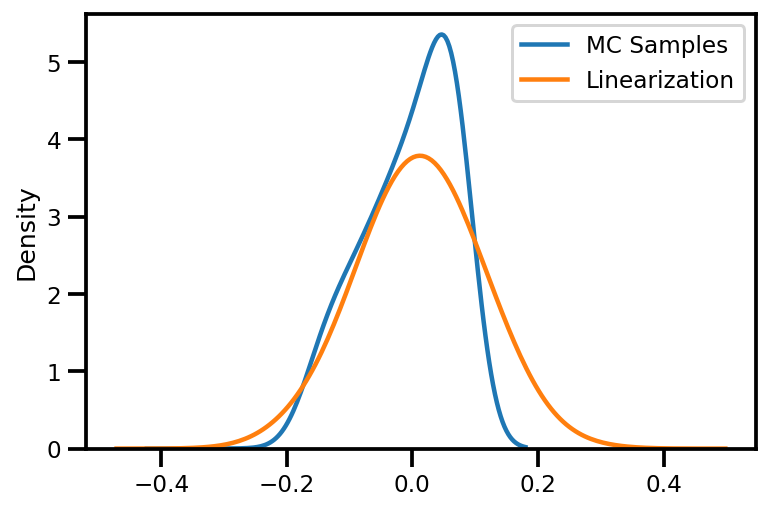

In [26]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, x=y_mc_samples, bw_adjust=3., label='MC Samples')
sns.kdeplot(ax=ax, x=lin_samples.squeeze(), bw_adjust=3., label='Linearization')
plt.legend()
plt.show()


## Moment Matching

#### Gauss-Hermite

In [27]:
from jaxkern.gp.uncertain.moment import MomentMatchingTransform, GaussHermite, UnscentedTransform, get_quadrature_sigma_points

In [28]:
degree = 100

# initialize model
# quadrature_model = GaussHermite(model, degree=degree, jitted=True)
mm_clf = MomentMatchingTransform(model, GaussHermite, degree=degree, jitted=False)

In [29]:
%%time
# calculate kernel expectations
psi0 = mm_clf.kernel_expectations.expectation_xkx(x_mu, x_cov[None, :])
psi1 = mm_clf.kernel_expectations.expectation_xkxy(x_mu, x_cov[None, :], mm_clf.model.X_train_)
psi2 = mm_clf.kernel_expectations.expectation_xkxyz(
    x_mu, x_cov[None, :], mm_clf.model.X_train_, mm_clf.model.X_train_
)

# calculate mean function

mm_mu = psi1 @ mm_clf.model.weights
# Q = self.K_inv - self.model.weights @ self.model.weights.T

# calculate variance function
t1 = psi0
print(t1)
t2 = np.trace(
    (psi2 @ (mm_clf.K_inv_ - mm_clf.model.weights @ mm_clf.model.weights.T)).T
)
print(t2)
t3 = np.trace(psi1.T @ psi1 @ mm_clf.model.weights @ mm_clf.model.weights.T)
t3 = mm_mu ** 2
print(t3)
mm_cov = t1 - t2 - t3
print(mm_cov)
t1.shape, t2.shape, t3.shape, mm_cov.shape
# 
# 
# return mean_ef, var_ef

[0.7795745]
[0.62141687]
[[3.7039325e-05]]
[[0.1581206]]
CPU times: user 2.21 s, sys: 23.9 ms, total: 2.24 s
Wall time: 2.21 s


((1,), (1,), (1, 1), (1, 1))

In [30]:
print(mm_mu, mm_cov, mm_cov**2)

[[-0.00608599]] [[0.1581206]] [[0.02500213]]


In [31]:
mm_samples = jax.random.multivariate_normal(key, mm_mu,  mm_cov**2, (n_mc_points,))

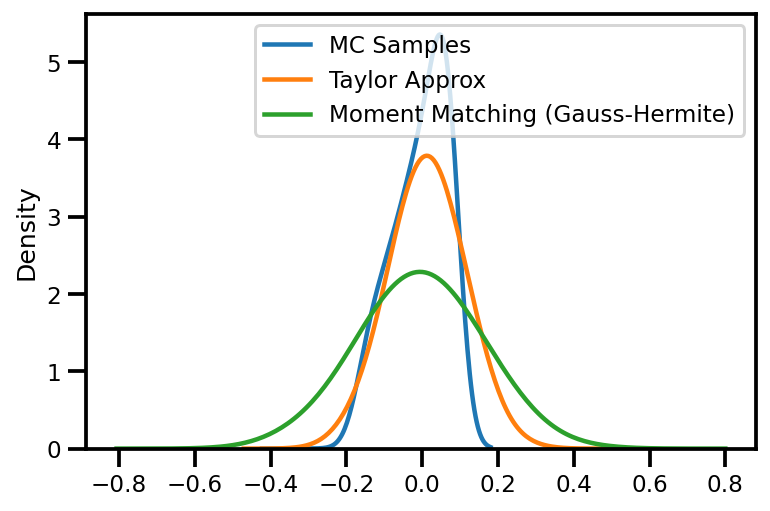

In [32]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, x=y_mc_samples, bw_adjust=3., label='MC Samples')
sns.kdeplot(ax=ax, x=lin_samples.squeeze(), bw_adjust=3., label='Taylor Approx')
sns.kdeplot(ax=ax, x=mm_samples.squeeze(), bw_adjust=3., label='Moment Matching (Gauss-Hermite)')
plt.legend()
plt.show()

### Unscented Transformation

In [33]:
degree = 20

# initialize model
# quadrature_model = GaussHermite(model, degree=degree, jitted=True)
mm_clf = MomentMatchingTransform(model, UnscentedTransform, jitted=False)

In [34]:
%%time
# calculate kernel expectations
psi0 = mm_clf.kernel_expectations.expectation_xkx(x_mu, x_cov[None, :])
psi1 = mm_clf.kernel_expectations.expectation_xkxy(x_mu, x_cov[None, :], mm_clf.model.X_train_)
psi2 = mm_clf.kernel_expectations.expectation_xkxyz(
    x_mu, x_cov[None, :], mm_clf.model.X_train_, mm_clf.model.X_train_
)

# calculate mean function

mm_mu = psi1 @ mm_clf.model.weights
# Q = self.K_inv - self.model.weights @ self.model.weights.T

# calculate variance function
t1 = psi0
t2 = np.trace(
    (psi2 @ (mm_clf.K_inv_ - mm_clf.model.weights @ mm_clf.model.weights.T)).T
)
t3 = np.trace(psi1.T @ psi1 @ mm_clf.model.weights @ mm_clf.model.weights.T)
t3 = mm_mu ** 2

mm_cov = t1 - t2 - t3

print(mm_mu, mm_cov, mm_cov**2)

[[-0.00612335]] [[0.15834641]] [[0.02507359]]
CPU times: user 993 ms, sys: 31.2 ms, total: 1.02 s
Wall time: 994 ms


In [35]:
unc_samples = jax.random.multivariate_normal(key, mm_mu,  mm_cov**2, (n_mc_points,))

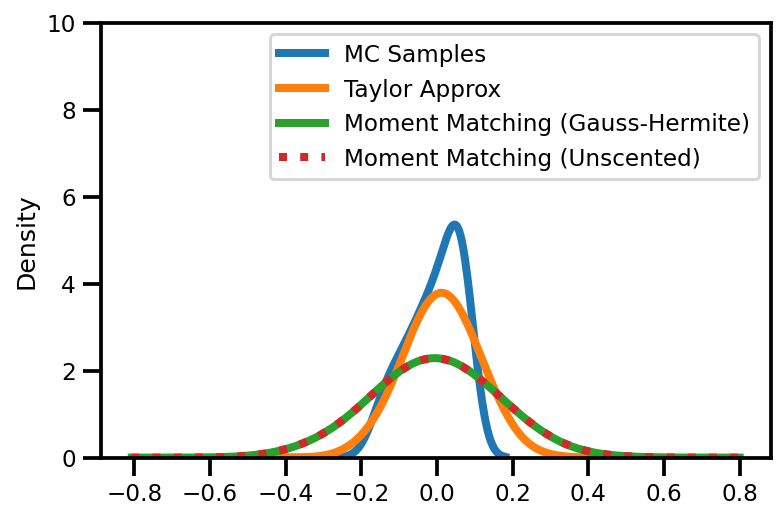

In [52]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, x=y_mc_samples, bw_adjust=3., linewidth=4,  label='MC Samples')
sns.kdeplot(ax=ax, x=lin_samples.squeeze(), bw_adjust=3., linewidth=4, label='Taylor Approx')
sns.kdeplot(ax=ax, x=mm_samples.squeeze(), bw_adjust=3., linewidth=4, label='Moment Matching (Gauss-Hermite)')
sns.kdeplot(ax=ax, x=unc_samples.squeeze(), bw_adjust=3., linewidth=4, linestyle=":", label='Moment Matching (Unscented)')
ax.set_ylim([0, 10])
plt.legend()
plt.show()